# Imports

In [1]:
import pyarrow as pa
import pyarrow.parquet as pq

import pandas as pd

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import numpy as np

import geopandas as gpd #heatmap

# Data loading

### BTC data

In [2]:
btc_price_data = pd.read_csv("data/BTC_ALL_graph_coinmarketcap.csv",sep=";")

#split off time of day
btc_price_data["timestamp"] = btc_price_data["timestamp"].apply(lambda x: str(x).split("T")[0]) 
btc_price_data = btc_price_data[["high", "timestamp"]]
btc_price_data.rename(columns={"timestamp": "date"}, inplace=True)


btc_price_data["year"] = btc_price_data["date"].apply(lambda x: int(str(x).split("-")[0]))

btc_price_data = btc_price_data[btc_price_data['year'] >= 2011]

display(btc_price_data.tail())

,high,date,year
726,26550.072937,2023-05-04,2023
727,25148.010374,2023-05-11,2023
728,25338.472061,2023-05-17,2023
729,25279.405768,2023-05-24,2023
730,26131.181703,2023-05-30,2023


### Actors data

In [3]:
actors = pq.read_table("data/actors.parquet")
actors_df = actors.to_pandas()

actors_df

,id,uri,label,jurisdictions,categories
0,bilaxy,bilaxy.com,Bilaxy,HK,exchange
1,banxa,banxa.com,Banxa,"AU, NL, US",exchange
2,aax,www.aax.com,Aax,SC,exchange
3,altcointrader,www.altcointrader.co.za,AltcoinTrader,ZA,exchange
4,azbit,azbit.com,Azbit,MH,exchange
...,...,...,...,...,...
309,stocksexchange,stex.com,Stex,EE,exchange
310,smenarnabitcoin,smenarnabitcoin.cz,Smenarnabitcoin,CZ,exchange
311,xapo,xapo.com,Xapo,US,"exchange, service"
312,yobit,yobit.net,YoBit,RU,exchange


### Flow data

In [4]:
flows = pq.read_table("data/flows.parquet")
flows_df = flows.to_pandas()

flows_df

,src_id,dst_id,value_asset,value_USD,date
0,1coin,1coin,36870000,243.755870,2014-03-03
1,1coin,1coin,380120000,2378.899210,2014-03-10
2,1coin,1coin,429150403,2738.687542,2014-03-13
3,1coin,1coin,333900098,2092.574397,2014-03-14
4,1coin,1coin,779334803,4938.373652,2014-03-15
...,...,...,...,...,...
1939582,zyado,zyado,1019592,11.368847,2017-03-21
1939583,zyado,zyado,1004152,13.325487,2017-04-29
1939584,zyado,zyado,39850720,5966.967603,2018-01-10
1939585,zyado,zyado,19251202,1730.115174,2018-04-27


### Country Codes

In [5]:
# Load country codes (source: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes)
country_codes = pd.read_csv('data/country_codes.csv')

display(country_codes.head())

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


### GDP (PPP) Data

In [6]:
# Load GDP data (PPP) (Source: https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD)
gdp = pd.read_csv('data/gdp.csv', skiprows=3)
gdp_meta = pd.read_csv('data/gdp_meta.csv')

display(gdp.head())
display(gdp_meta.head())

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,36846.848285,37343.912963,37583.840323,38865.188195,41679.238190,42501.641554,34971.009913,42698.359872,NaN,NaN
1,Africa Eastern and Southern,AFE,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3470.550675,3498.125396,3591.099809,3635.564622,3724.868177,3777.972368,3621.058106,3839.470058,NaN,NaN
2,Afghanistan,AFG,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2110.829568,2128.125938,2023.834656,2096.093111,2109.929296,2167.704111,2076.138380,1665.805842,NaN,NaN
3,Africa Western and Central,AFW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4143.177054,4075.994459,3998.951876,4045.303263,4160.540965,4264.731035,4174.504565,4409.450961,NaN,NaN
4,Angola,AGO,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,8123.048065,7274.090475,7027.146634,7216.061373,7042.923829,6881.076241,6362.636076,6491.125578,NaN,NaN


,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,NaN
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central,NaN
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola,NaN


### Population data

In [7]:
# Load Population data (Source: https://data.worldbank.org/indicator/SP.POP.TOTL)
population = pd.read_csv('data/population.csv', skiprows=3)

display(population.head())

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,...,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,NaN,NaN
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,...,583650827.0,600008150.0,616377331.0,632746296.0,649756874.0,667242712.0,685112705.0,702976832.0,NaN,NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,...,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,NaN,NaN
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,...,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0,NaN,NaN
4,Angola,AGO,"Population, total",SP.POP.TOTL,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,...,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0,34503774.0,NaN,NaN


### Tax Haven data

In [8]:
# Load tax haven data (Source: https://www.taxjustice.net)
# Waiting for download confirmation

### Corruption data

In [9]:
# Load Corruption Perception data (Source: https://www.transparency.org via https://www.kaggle.com/datasets/jeegarmaru/corruption-perceptions-index-for-10-years?select=merged_cpi_data.csv)
cpi = pd.read_csv('data/cpi_data.csv')

display(cpi.head())

,Year,Country,CPI Score,Rank,Number of Sources,Minimum score,Maximum score,Standard Error,90% Confidence Interval (Higher bound),90% Confidence Interval (Lower bound),...,WJP,ISO3,Region,WB Code,OECD,G20,BRICS,EU,Arab states,IFS Code
0,2010,Denmark,93.0,1,6,89.0,95.0,2.0,94.0,91.0,...,NaN,DNK,WE/EU,DNK,y,NaN,NaN,y,NaN,128.0
1,2010,New Zealand,93.0,1,6,89.0,95.0,2.0,95.0,92.0,...,NaN,NZL,AP,NZL,y,NaN,NaN,NaN,NaN,196.0
2,2010,Singapore,93.0,1,9,89.0,95.0,2.0,94.0,92.0,...,NaN,SGP,AP,SGP,NaN,NaN,NaN,NaN,NaN,576.0
3,2010,Finland,92.0,4,6,89.0,95.0,2.0,93.0,91.0,...,NaN,FIN,WE/EU,FIN,y,NaN,NaN,y,NaN,172.0
4,2010,Sweden,92.0,4,6,89.0,95.0,2.0,94.0,91.0,...,NaN,SWE,WE/EU,SWE,y,NaN,NaN,y,NaN,144.0


# Data exploration

Lets see how the jurisdictions are "distributed"

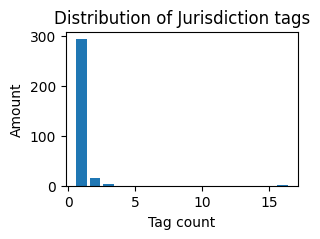

jurisdictions
1     294
2      16
3       3
16      1
Name: count, dtype: int64

In [10]:
# Compute the comma count for each value in the "jurisdictions" column
comma_count_stats = actors_df['jurisdictions'].apply(lambda x: str(x).count(',')+1).value_counts().sort_index()

plt.figure(figsize=(3, 2)) 
plt.bar(comma_count_stats.index, comma_count_stats.values)
plt.xlabel('Tag count')
plt.ylabel('Amount')
plt.title('Distribution of Jurisdiction tags')
plt.show()

comma_count_stats

who has 16 jurisdictions????

In [11]:
actors_df[actors_df['jurisdictions'].str.count(',') == 15]

,id,uri,label,jurisdictions,categories
35,binance,binance.com,"Binance (US, DEX)","AE, AU, BH, CA, CY, ES, FR, IT, KY, KZ, LT, MT...","defi_dex, exchange, mining_service, organization"


In [12]:
actors_df[actors_df['id'].str.contains("inance")== True]

,id,uri,label,jurisdictions,categories
35,binance,binance.com,"Binance (US, DEX)","AE, AU, BH, CA, CY, ES, FR, IT, KY, KZ, LT, MT...","defi_dex, exchange, mining_service, organization"


of course its binance LOL

In which timeframe was the flow data collected?

In [13]:
# Flow data from - to
print(f'Flow data recorded from {flows_df.date.min()} to {flows_df.date.max()}')

Flow data recorded from 2011-05-13 to 2023-04-12


In [14]:
print(f'Flows before merging actor data {flows_df.shape[0]}')
merged_df = pd.merge(flows_df, actors_df.add_prefix('src_'), on='src_id', how='inner')
merged_df = pd.merge(merged_df, actors_df.add_prefix('dst_'), on='dst_id', how='inner')
print(f'Flows after merging actor data {merged_df.shape[0]}')
display(merged_df.head())

Flows before merging actor data 1939587
Flows after merging actor data 1904481


,src_id,dst_id,value_asset,value_USD,date,src_uri,src_label,src_jurisdictions,src_categories,dst_uri,dst_label,dst_jurisdictions,dst_categories
0,1coin,1coin,36870000,243.755870,2014-03-03,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
1,1coin,1coin,380120000,2378.899210,2014-03-10,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
2,1coin,1coin,429150403,2738.687542,2014-03-13,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
3,1coin,1coin,333900098,2092.574397,2014-03-14,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
4,1coin,1coin,779334803,4938.373652,2014-03-15,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange


In [15]:
# merge in btc course data
merged_df = pd.merge(merged_df,btc_price_data,on="date",how='inner')

In [16]:
# Types
merged_df['date'] = pd.to_datetime(merged_df['date'])

lets see how much of the traffic is from or to binance

In [17]:
# calc overall traffic per year
yearly = merged_df.groupby(["year"])["value_USD"].sum().reset_index()
yearly.rename(columns={"value_USD":"value_usd_with"},inplace=True)

yearly_without_binance = merged_df[merged_df["src_label"].str.contains("inance") == False]
yearly_without_binance = yearly_without_binance[yearly_without_binance["dst_label"].str.contains("inance") == False]

yearly["value_usd_without"] = yearly_without_binance.groupby(["year"])["value_USD"].sum().reset_index()["value_USD"]
yearly["binance portion"] = 1-(yearly["value_usd_without"]/yearly["value_usd_with"])

display(yearly)

,year,value_usd_with,value_usd_without,binance portion
0,2011,1.345420e+04,1.345420e+04,0.000000
1,2012,3.172178e+05,3.172178e+05,0.000000
2,2013,4.137246e+07,4.137246e+07,0.000000
3,2014,3.008547e+08,3.008547e+08,0.000000
4,2015,8.015531e+08,8.015531e+08,0.000000
5,2016,1.853461e+09,1.853461e+09,0.000000
6,2017,1.606032e+10,1.447801e+10,0.098523
7,2018,2.139878e+10,1.502060e+10,0.298063
8,2019,2.866707e+10,2.417080e+10,0.156844
9,2020,4.159369e+10,2.928045e+10,0.296036


In [18]:
# Transform jurisdiction string into list element
merged_df = merged_df.assign(src_jurisdictions=merged_df.src_jurisdictions.str.split(','))
merged_df = merged_df.assign(dst_jurisdictions=merged_df.dst_jurisdictions.str.split(','))
# Create year column
merged_df['year'] = merged_df.date.dt.year

display(merged_df.tail())

# Split up amounts by number of src and dst countries
merged_df['src_value_asset'] = merged_df.apply(lambda row: row['value_asset'] / len(row['src_jurisdictions']) if row['src_jurisdictions'] is not None else row['value_asset'], axis=1)
merged_df['dst_value_asset'] = merged_df.apply(lambda row: row['value_asset'] / len(row['dst_jurisdictions']) if row['dst_jurisdictions'] is not None else row['value_asset'], axis=1)
merged_df['src_value_USD'] = merged_df.apply(lambda row: row['value_USD'] / len(row['src_jurisdictions']) if row['src_jurisdictions'] is not None else row['value_USD'], axis=1)
merged_df['dst_value_USD'] = merged_df.apply(lambda row: row['value_USD'] / len(row['dst_jurisdictions']) if row['dst_jurisdictions'] is not None else row['value_USD'], axis=1)

# Create separate columns for each jurisdiction (if we want to split the amounts we have to split amount before)
merged_df = merged_df.explode('dst_jurisdictions')
merged_df = merged_df.explode('src_jurisdictions')

# Strip whitespace
merged_df.dst_jurisdictions = merged_df.dst_jurisdictions.str.strip()
merged_df.src_jurisdictions = merged_df.src_jurisdictions.str.strip()
# Remove flows which aren't x-border
merged_df = merged_df[merged_df['dst_jurisdictions'] != merged_df['src_jurisdictions']]

#display(merged_df.groupby(['year', 'dst_jurisdictions'])["open"].max())
# divide by btc value
# Do we really need this? Isn't value_asset already the number of tokens?
merged_df["value_BTC"] = merged_df["value_USD"] / merged_df["high"]

# Group by year and juristicion
dst_amounts = merged_df.groupby(['year', 'dst_jurisdictions'])[['value_USD', 'dst_value_asset', 'dst_value_USD', 'value_BTC',"src_label","dst_label"]].sum().reset_index()
dst_amounts = dst_amounts.rename(columns={"dst_jurisdictions":"jurisdictions"})

src_amounts = merged_df.groupby(['year', 'src_jurisdictions'])[['value_USD', 'src_value_asset', 'src_value_USD', 'value_BTC',"src_label","dst_label"]].sum().reset_index()
src_amounts = src_amounts.rename(columns={"src_jurisdictions":"jurisdictions"})

display(dst_amounts)
display(src_amounts)

,src_id,dst_id,value_asset,value_USD,date,src_uri,src_label,src_jurisdictions,src_categories,dst_uri,dst_label,dst_jurisdictions,dst_categories,high,year
295753,virwox,virwox,412000001,36.012922,2011-05-31,virwox.com,Virwox,[AT],exchange,virwox.com,Virwox,[AT],exchange,8.758259,2011
295754,virwox,virwox,1000000,0.185499,2011-06-06,virwox.com,Virwox,[AT],exchange,virwox.com,Virwox,[AT],exchange,17.804963,2011
295755,virwox,virwox,12969814,2.271014,2011-06-25,virwox.com,Virwox,[AT],exchange,virwox.com,Virwox,[AT],exchange,16.543933,2011
295756,virwox,virwox,67982084,9.388327,2011-07-15,virwox.com,Virwox,[AT],exchange,virwox.com,Virwox,[AT],exchange,13.829063,2011
295757,campbx,campbx,1002575,0.138456,2011-07-15,campbx.com,Campbx,[US],exchange,campbx.com,Campbx,[US],exchange,13.829063,2011


,year,jurisdictions,value_USD,dst_value_asset,dst_value_USD,value_BTC,src_label,dst_label
0,2011,AT,3.304020e+02,1.049084e+10,3.304020e+02,9.626424e+01,Btc-EBtc-EBtc-E,VirwoxVirwoxVirwox
1,2011,AU,1.213176e+03,3.726010e+10,1.213176e+03,3.689185e+02,bitcoin.deVircurexVircurexVircurexVircurexCavi...,Btc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-E
2,2011,BZ,3.004253e+01,3.805526e+08,1.502127e+01,6.567382e+00,Btc-EVircurexVircurex,VircurexVircurexVircurex
3,2011,CA,4.165230e+02,1.049526e+10,4.165230e+02,9.402139e+01,Btc-EBtc-EBtc-EBtc-E,CavirtexCavirtexCavirtexCavirtex
4,2011,CN,3.004253e+01,3.805526e+08,1.502127e+01,6.567382e+00,Btc-EVircurexVircurex,VircurexVircurexVircurex
...,...,...,...,...,...,...,...,...
522,2023,TW,6.800703e+06,2.523528e+10,6.800703e+06,2.672580e+02,"Binance (US, DEX)Binance (US, DEX)Binance (US,...",Max MaicoinMax MaicoinMax MaicoinMax MaicoinMa...
523,2023,US,4.871824e+10,3.506130e+13,8.102749e+09,2.192454e+06,"Binance (US, DEX)Binance (US, DEX)Binance (US,...","Binance (US, DEX)Binance (US, DEX)Binance (US,..."
524,2023,VG,1.846449e+07,6.962437e+10,1.846449e+07,7.231166e+02,"Binance (US, DEX)Binance (US, DEX)Binance (US,...",LBankLBankLBankLBankLBankLBankLBankLBankLBankL...
525,2023,VN,2.856750e+04,1.189241e+08,2.856750e+04,1.269132e+00,"Binance (US, DEX)Binance (US, DEX)Binance (US,...",VindaxVindaxVindaxVindaxVindaxVindaxVindaxVind...


,year,jurisdictions,value_USD,src_value_asset,src_value_USD,value_BTC,src_label,dst_label
0,2011,AT,2.778538e+03,7.049400e+10,2.778538e+03,6.092279e+02,VirwoxVirwox,BtccTheRockTrading
1,2011,AU,9.275158e+02,2.651036e+10,9.275158e+02,2.366523e+02,Btc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EB...,CavirtexCavirtexBtccVircurexVircurexVirwoxBitc...
2,2011,BZ,1.476522e+02,1.778907e+09,7.382611e+01,3.096896e+01,VircurexVircurexVircurexVircurex,Btc-EVircurexBtc-EVircurex
3,2011,CA,5.101930e+01,1.701000e+09,5.101930e+01,1.405646e+01,CavirtexCavirtexCavirtexCavirtexCavirtex,BitcoinicaBtc-EBtc-EBitcoinicaBitcoinica
4,2011,CN,1.476522e+02,1.778907e+09,7.382611e+01,3.096896e+01,VircurexVircurexVircurexVircurex,Btc-EVircurexBtc-EVircurex
...,...,...,...,...,...,...,...,...
498,2023,TR,2.092071e+08,9.507812e+11,2.092071e+08,9.927581e+03,BtcTurk PROBtcTurk PROBtcTurk PROBtcTurk PROBt...,"BiboxBinance (US, DEX)Binance (US, DEX)Binance..."
499,2023,TW,7.017710e+07,2.893594e+11,7.017710e+07,2.946630e+03,Max MaicoinMax MaicoinMax MaicoinMax MaicoinMa...,"MEXC GlobalBinance (US, DEX)Binance (US, DEX)B..."
500,2023,US,4.576278e+10,2.101914e+13,4.833558e+09,2.060826e+06,"Binance (US, DEX)CoinbaseBinance (US, DEX)Coin...","CexCexHuobiHuobiHuobiBinance (US, DEX)Binance ..."
501,2023,VG,9.012389e+05,3.892722e+09,9.012389e+05,3.957086e+01,BKEXBKEXBKEXBKEXBKEXBKEXBKEXBKEXBKEXBKEXBKEXBK...,"CoinbaseCoinbaseBinance (US, DEX)Binance (US, ..."


### How does the general trend look like?

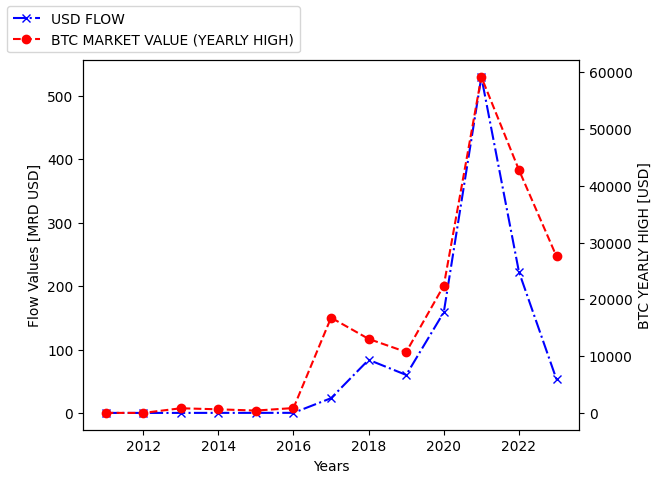

In [19]:
def test_plot(flow_data, btc_data):
    _flow_data = flow_data.groupby('year')["src_value_USD"].sum()/1000000000
    _btc_data = btc_data.groupby('year')["high"].max()

    fig, ax1 = plt.subplots()

    # Plotting the bar plot
    ax1.plot(_flow_data.index, _flow_data.values, color='blue',marker="x",linestyle="dashdot",label="USD FLOW")
    ax1.set_ylabel('Flow Values [MRD USD]')
    ax2 = ax1.twinx()

    # Plotting the line plot
    ax2.plot(_flow_data.index, _btc_data.values, color='red', marker='o', linestyle="dashed",label="BTC MARKET VALUE (YEARLY HIGH)")
    ax2.set_ylabel('BTC YEARLY HIGH [USD]')
    ax1.set_xlabel('Years')
    fig.legend(loc='upper left',ncol=1)

    #plt.tight_layout()

test_plot(src_amounts, btc_price_data)
#test_plot(dst_amounts)

looks like Flow value and the BTC market value correlate - does that mean that the amount of BTC flowing (=flow value/ btc market value) is constant? Lets see

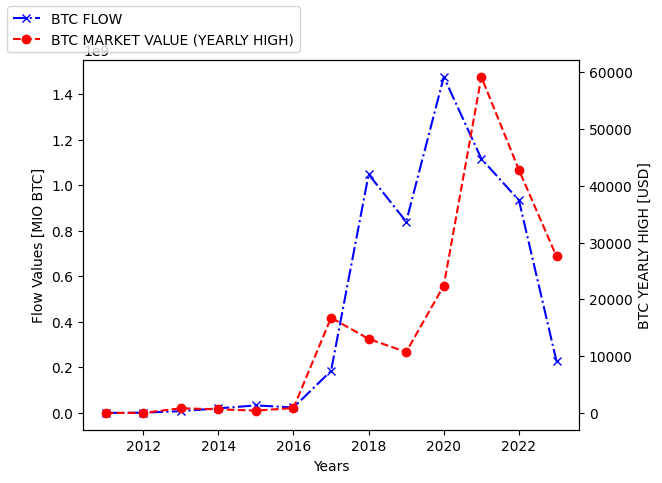

In [20]:
def test_plot2(flow_data,btc_data):
    # TODO: can we use the assets or should we use BTC_value?
    _flow_data = flow_data.groupby('year')["src_value_asset"].sum()/1000000
    _btc_data = btc_data.groupby('year')["high"].max()

    fig, ax1 = plt.subplots()

    # Plotting the bar plot
    ax1.plot(_flow_data.index, _flow_data.values, color='blue',marker="x",linestyle="dashdot",label="BTC FLOW")
    ax1.set_ylabel('Flow Values [MIO BTC]')
    ax2 = ax1.twinx()

    # Plotting the line plot
    ax2.plot(_flow_data.index, _btc_data.values, color='red', marker='o', linestyle="dashed",label="BTC MARKET VALUE (YEARLY HIGH)")
    ax2.set_ylabel('BTC YEARLY HIGH [USD]')
    ax1.set_xlabel('Years')
    fig.legend(loc='upper left',ncol=1)

test_plot2(src_amounts,btc_price_data)

how are the flows distributed over the jurisdictions?

In [21]:
def plot_juri_bars(data1,data2,year,label):
    #x = dst_amounts["jurisdictions"].unique()
    data1 = data1.sort_values("jurisdictions",ascending=False)
    filtered_data1 = [d for d in zip(data1['year'],data1['jurisdictions'], data1['src_value_USD']/1000000000) if d[0] == year]

    data2 = data2.sort_values("jurisdictions",ascending=False)
    filtered_data2 = [d for d in zip(data2['year'],data2['jurisdictions'], data2['dst_value_USD']/1000000000) if d[0] == year]

    x = dst_amounts["jurisdictions"].unique()

    #display(filtered_data)
    # Separate the x and y values
    x1 = [d[1] for d in filtered_data1]
    y1 = [d[2] for d in filtered_data1]

    x2 = [d[1] for d in filtered_data2]
    y2 = [d[2] for d in filtered_data2]

    fig, (ax1,ax2)= plt.subplots(2,1,figsize=(10,5))

    # Plot the bar chart
    ax1.bar(x1, y1)
    # Set labels and title
    ax1.set_xlabel('Jurisdictions')
    ax1.set_ylabel('Value (MRD USD)')

    # Plot the bar chart
    ax2.bar(x1, y1)
    # Set labels and title
    ax2.set_xlabel('Jurisdictions')
    ax2.set_ylabel('Value (MRD USD)')

    # Rotate x-axis labels for better visibility
    ax1.tick_params(axis='x', rotation=90)
    ax2.tick_params(axis='x', rotation=90)

    # Display the plot
    plt.show()

interact(plot_juri_bars,data1=fixed(src_amounts),data2=fixed(dst_amounts),year=(2012,2022,1),label=fixed("Source values by jurisdictions in"))

interactive(children=(IntSlider(value=2017, description='year', max=2022, min=2012), Output()), _dom_classes=(…

<function __main__.plot_juri_bars(data1, data2, year, label)>

they are all prettymuch "the same" - maybe because binance is in just those juris? lets see

In [22]:
src_filterd = src_amounts[src_amounts["src_label"].str.contains("inance") == False]
src_filterd = src_filterd[src_filterd["dst_label"].str.contains("inance") == False]

dst_filterd = dst_amounts[dst_amounts["src_label"].str.contains("inance") == False]
dst_filterd = dst_filterd[dst_filterd["dst_label"].str.contains("inance") == False]


interact(plot_juri_bars,data1=fixed(src_filterd),data2=fixed(dst_filterd),year=(2012,2022,1),label=fixed("Source values by jurisdictions in"))

interactive(children=(IntSlider(value=2017, description='year', max=2022, min=2012), Output()), _dom_classes=(…

<function __main__.plot_juri_bars(data1, data2, year, label)>

In [26]:
result = src_amounts.copy()
result['value_USD'] = src_amounts['src_value_USD'].sub(dst_amounts['dst_value_USD'], axis=0)

interact(plot_juri_bars,data1=fixed(result),data2=fixed(result),year=(2012,2022,1),label=fixed("Holdings by jurisdictions in"))

result = result.groupby(['jurisdictions'])['value_USD'].sum().reset_index()
result = result.sort_values("jurisdictions",ascending=True)
plt.figure(figsize=(10, 5))
    # Plot the bar chart
plt.bar(result['jurisdictions'], result['value_USD'])
    # Set labels and title
plt.xlabel('Jurisdictions')
plt.ylabel('Value (USD)')
plt.title('Holdings by Jurisdiction overall')
    # Rotate x-axis labels for better visibility
plt.xticks(rotation=90)
    # Display the plot
plt.show()

## How do the holds look like on a map?

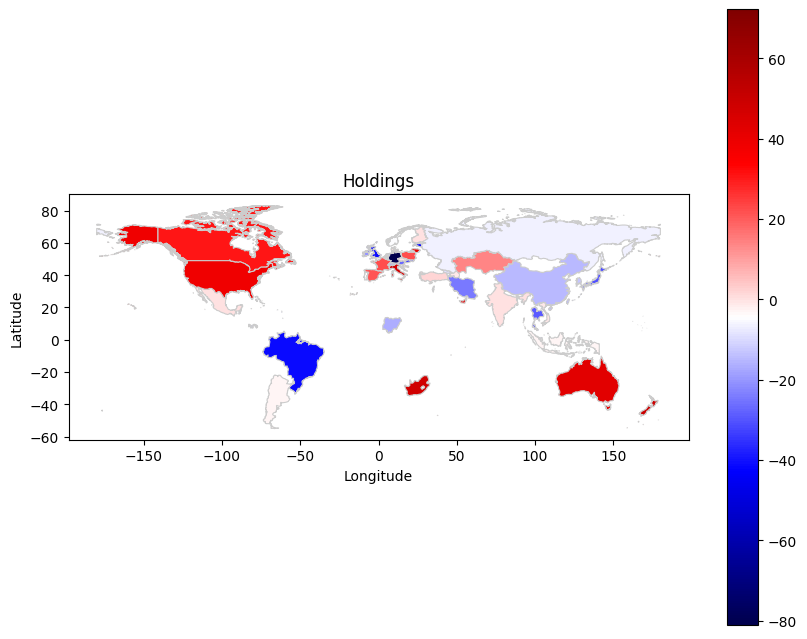

In [24]:
result.rename(columns={'jurisdictions':'alpha-2'},inplace=True)
country_codes = pd.read_csv('data/country_codes.csv')
country_codes = country_codes[['alpha-2','alpha-3']]
merged_df= pd.merge(result, country_codes,on='alpha-2',how='inner')
merged_df.rename(columns={'alpha-2':'ISO'},inplace=True)

map_data = gpd.read_file('shapefile/World_Countries__Generalized_.shp')

merged_data = map_data.merge(merged_df, on='ISO')
fig, ax = plt.subplots(figsize=(10, 8))
merged_data["value_USD"] = merged_data["value_USD"]/1000000000
merged_data.plot(column='value_USD', cmap='seismic', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Holdings')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [25]:

# Merge country codes first
print(f'Dest Rows before merge: {dst_amounts.shape[0]}')
dst = pd.merge(dst_amounts, country_codes[['alpha-2', 'alpha-3', 'region', 'sub-region']], left_on='dst_jurisdictions', right_on='alpha-2', how='left')

print(f'Src rows before merge: {src_amounts.shape[0]}')
src = pd.merge(src_amounts, country_codes[['alpha-2', 'alpha-3', 'region', 'sub-region']], left_on='src_jurisdictions', right_on='alpha-2', how='inner')
#display(src.head())

# Now merge gdp data
dst = pd.merge(dst, gdp, left_on='alpha-3', right_on='Country Code', how='left')
print(f'Dest rows after merge: {dst.shape[0]}')

src = pd.merge(src, gdp, left_on='alpha-3', right_on='Country Code', how='inner')
print(f'Src rows after merge: {src.shape[0]}')

print(display(dst[dst['alpha-3'].isna()]))

Dest Rows before merge: 527


KeyError: "['region', 'sub-region'] not in index"